# Trajectory Analysis using 10x Single Cell Gene Expression Data
More details on this analysis can be found in the 10x Genomics Analysis Guides tutorial, located here: https://www.10xgenomics.com/resources/analysis-guides/trajectory-analysis-using-10x-Genomics-single-cell-gene-expression-data

This will install the required Python library packages needed for this tutorial. 

In [1]:
!pip install numpy pandas matplotlib scanpy igraph scvelo loompy anndata

     |████████████████████████████████| 1.8MB 2.2MB/s eta 0:00:01
     |████████████████████████████████| 204kB 9.3MB/s eta 0:00:01
     |████████████████████████████████| 4.8MB 21.4MB/s eta 0:00:01
  Stored in directory: /Users/lisa.johnson/Library/Caches/pip/wheels/fb/1d/ec/796f262c5df2ff8decf1802494e428513dc6e50345892c2525
Successfully built loompy
ERROR: scvelo 0.2.4 has requirement anndata>=0.7.5, but you'll have anndata 0.7.1 which is incompatible.
ERROR: scvelo 0.2.4 has requirement matplotlib>=3.3.0, but you'll have matplotlib 3.1.3 which is incompatible.
ERROR: scvelo 0.2.4 has requirement scanpy>=1.5, but you'll have scanpy 1.4.5.2.dev20+ge871dd3c which is incompatible.


This will create a new directory called "input-files", then download and extract several input data files needed for this tutorial, then display the list of files now available.

In [2]:
!mkdir input-files
!curl -o input-files/filtered_feature_bc_matrix.tar.gz https://cf.10xgenomics.com/supp/cell-exp/neutrophils/filtered_feature_bc_matrix.tar.gz
!curl -o input-files/WB_Lysis_3p_Introns_8kCells.loom https://cf.10xgenomics.com/supp/cell-exp/neutrophils/WB_Lysis_3p_Introns_8kCells.loom
!curl -o input-files/3p-Neutrophils-clusters.csv https://cf.10xgenomics.com/supp/cell-exp/neutrophils/3p-Neutrophils-clusters.csv
!curl -o input-files/3p-Neutrophils-UMAP-Projection.csv https://cf.10xgenomics.com/supp/cell-exp/neutrophils/3p-Neutrophils-UMAP-Projection.
!tar -xvzf input-files/filtered_feature_bc_matrix.tar.gz -C input-files/
!ls -lah input-files

mkdir: input-files: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.2M  100 16.2M    0     0  5500k      0  0:00:03  0:00:03 --:--:-- 5500k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67.5M  100 67.5M    0     0  6620k      0  0:00:10  0:00:10 --:--:-- 7190k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 96967  100 96967    0     0      0      0 --:--:-- --:--:-- --:--:--     00   175k      0 --:--:-- --:--:-- --:--:--  175k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   243    0   243    0     0    960      0 --:--

In [1]:
# First, import required packages in the current session.

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc
import igraph
import scvelo as scv
import loompy as lmp
import anndata

import warnings
warnings.filterwarnings('ignore')

This chunk of code below is used to customize colors for the cluster and plot sizes

In [2]:
# Customize parameters for plots (Size, Color, etc)
scv.set_figure_params(style="scvelo")
pl.rcParams["figure.figsize"] = (10,10)
Colorss=["#E41A1C","#377EB8","#4DAF4A","#984EA3","#FF7F00","#FFFF33","#A65628","#F781BF"]

Import the GEX matrix along with the clusters and UMAP embeddings from Loupe.



In [4]:
# Define Path to cellranger output
Path10x='./input-files/filtered_feature_bc_matrix/'

# Read cellranger output
Neutro3p = sc.read_10x_mtx(Path10x,var_names='gene_symbols',cache=True)

Neutro3p

AnnData object with n_obs × n_vars = 8000 × 36601
    var: 'gene_ids', 'feature_types'

In [6]:
# Read Clusters exported from Loupe Browser 
Clusters_Loupe = pd.read_csv("./input-files/3p-Neutrophils-clusters.csv", delimiter=',',index_col=0)

# Create list with Neutrophil Barcodes
Neutrophils_BCs = Clusters_Loupe.index

# Read UMAP exported from Loupe Browser 
UMAP_Loupe = pd.read_csv("./input-files/3p-Neutrophils-UMAP-Projection.csv", delimiter=',',index_col=0)

# Select Neutrophil Barcodes
UMAP_Loupe = UMAP_Loupe.loc[Neutrophils_BCs,]

# Tansform to Numpy
UMAP_Loupe = UMAP_Loupe.to_numpy()

# Filter Cells to only Neutrophils
Neutro3p = Neutro3p[Neutrophils_BCs]

# Add Clusters from Loupe to object
Neutro3p.obs['Loupe'] = Clusters_Loupe

# Add UMAP from Loupe to object
Neutro3p.obsm["X_umap"] = UMAP_Loupe

Neutro3p

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 3343 × 36601
    obs: 'Loupe'
    var: 'gene_ids', 'feature_types'
    obsm: 'X_umap'

You might get this warning below, but nothing to worry about.
> Trying to set attribute `.obs` of view, copying.

Next, read velocyto output and merge

In [8]:
# Read velocyto output
VelNeutro3p = scv.read('./input-files/WB_Lysis_3p_Introns_8kCells.loom', cache=True)

# Merge velocyto and cellranger outputs
Neutro3p = scv.utils.merge(Neutro3p, VelNeutro3p)

Neutro3p

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 3343 × 36601
    obs: 'Loupe', 'Clusters', '_X', '_Y', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

You might get this warning, but no need to worry:
> Variable names are not unique. To make them unique, call `.var_names_make_unique`.

Next, process dataset and obtain latent time values for each cell


In [10]:
# Standard scvelo processing to run Dynamical Mode
scv.pp.filter_and_normalize(Neutro3p, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(Neutro3p, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(Neutro3p)
scv.tl.velocity(Neutro3p, mode='dynamical')
scv.tl.velocity_graph(Neutro3p)
scv.tl.recover_latent_time(Neutro3p)

Neutro3p

Filtered out 143 genes that are detected 30 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/96 cores)


  0%|          | 0/35 [00:00<?, ?gene/s]

    finished (0:00:14) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/96 cores)


  0%|          | 0/3343 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


AnnData object with n_obs × n_vars = 3343 × 990
    obs: 'Loupe', 'Clusters', '_X', '_Y', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'gene_ids', 'feature_types', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'pca', 'neighbors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs', 'loss'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_Neutrophils-scVelo-cluster.png


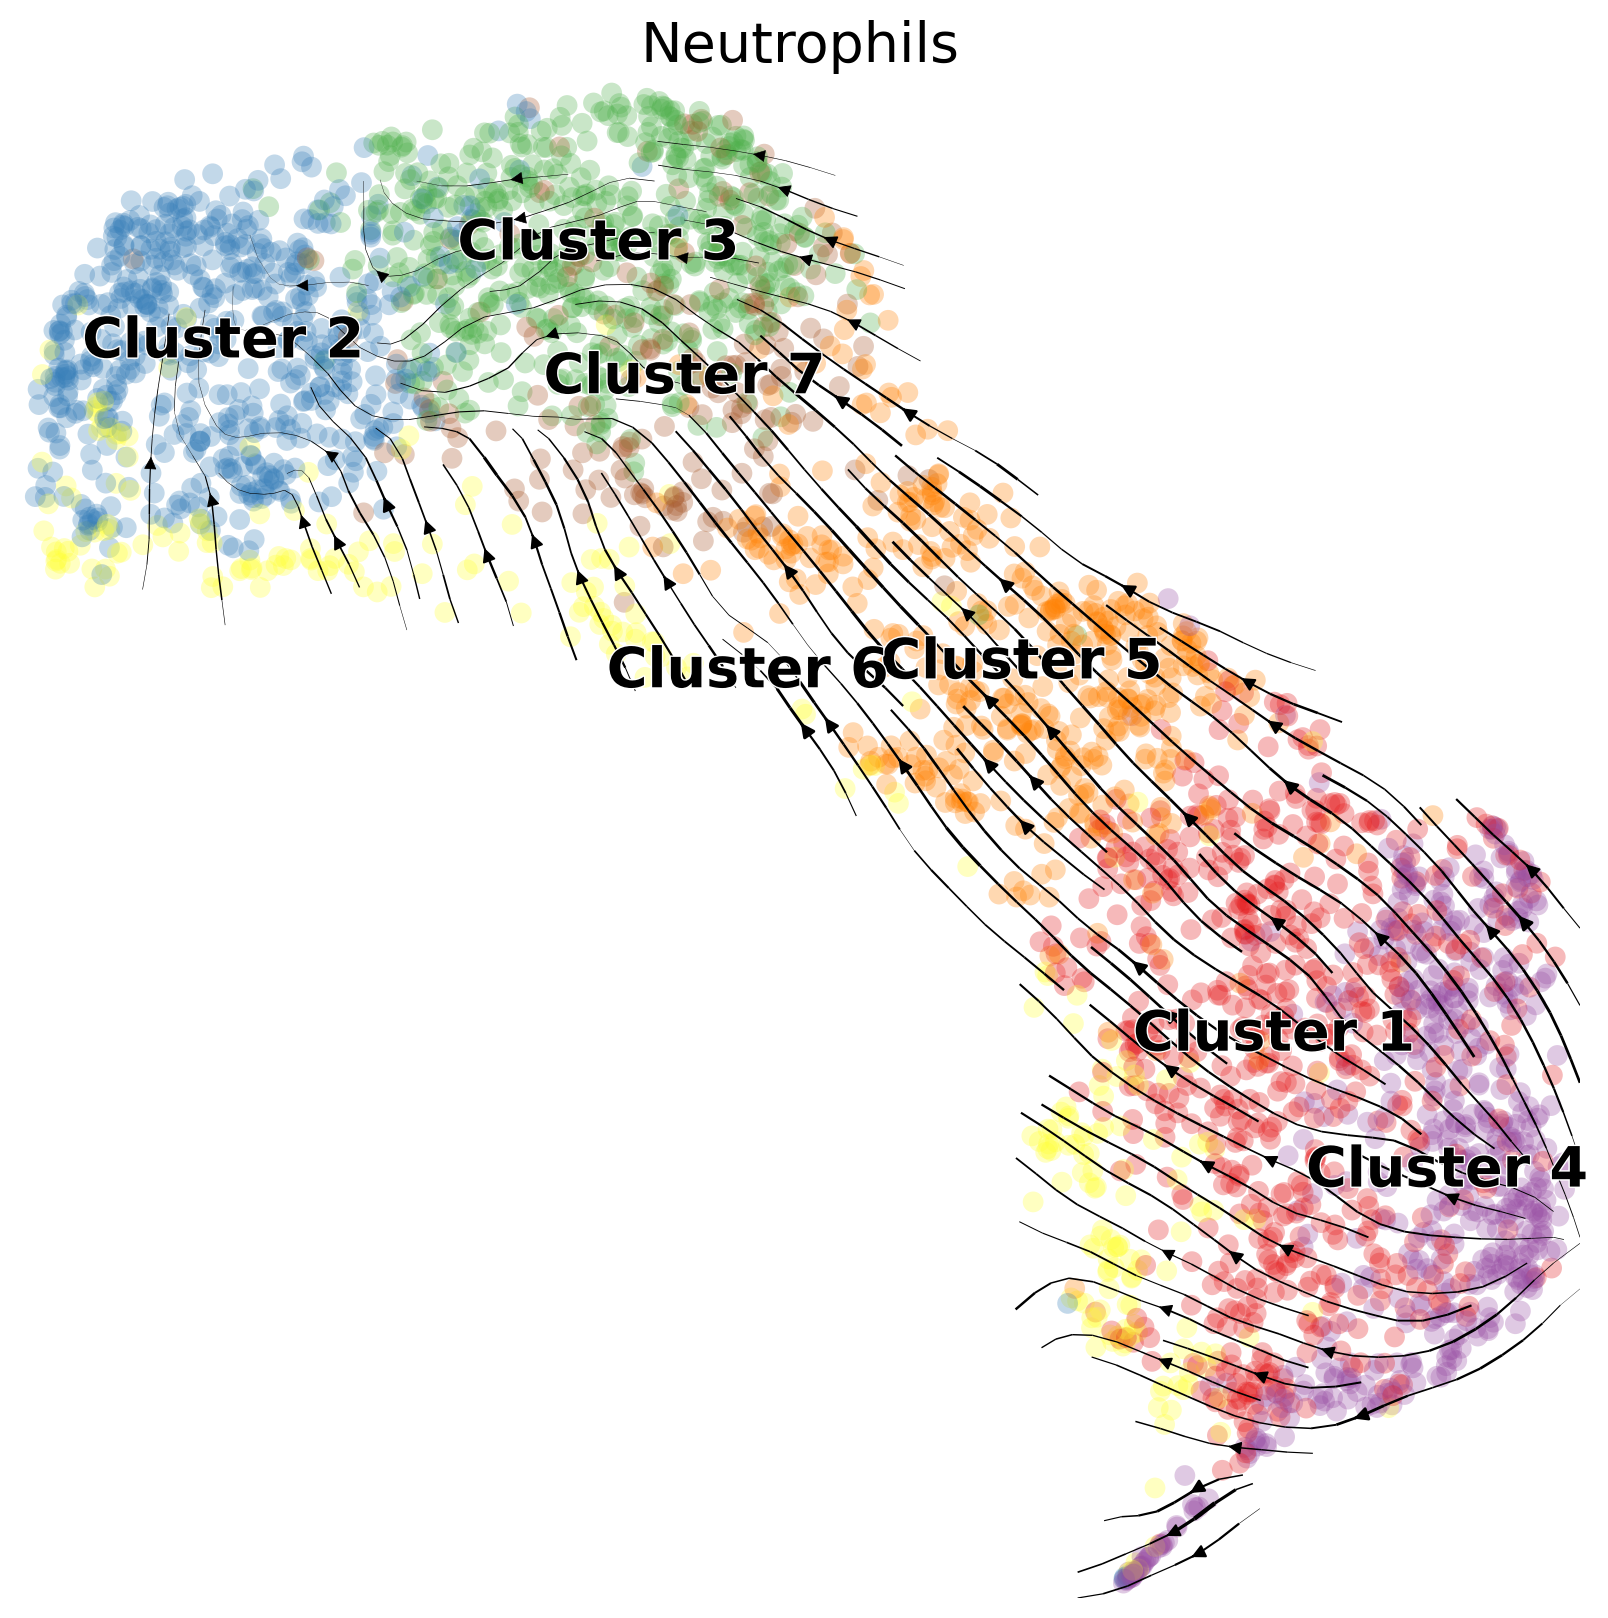

saving figure to file ./figures/scvelo_Neutrophils-scVelo-latenttime.png


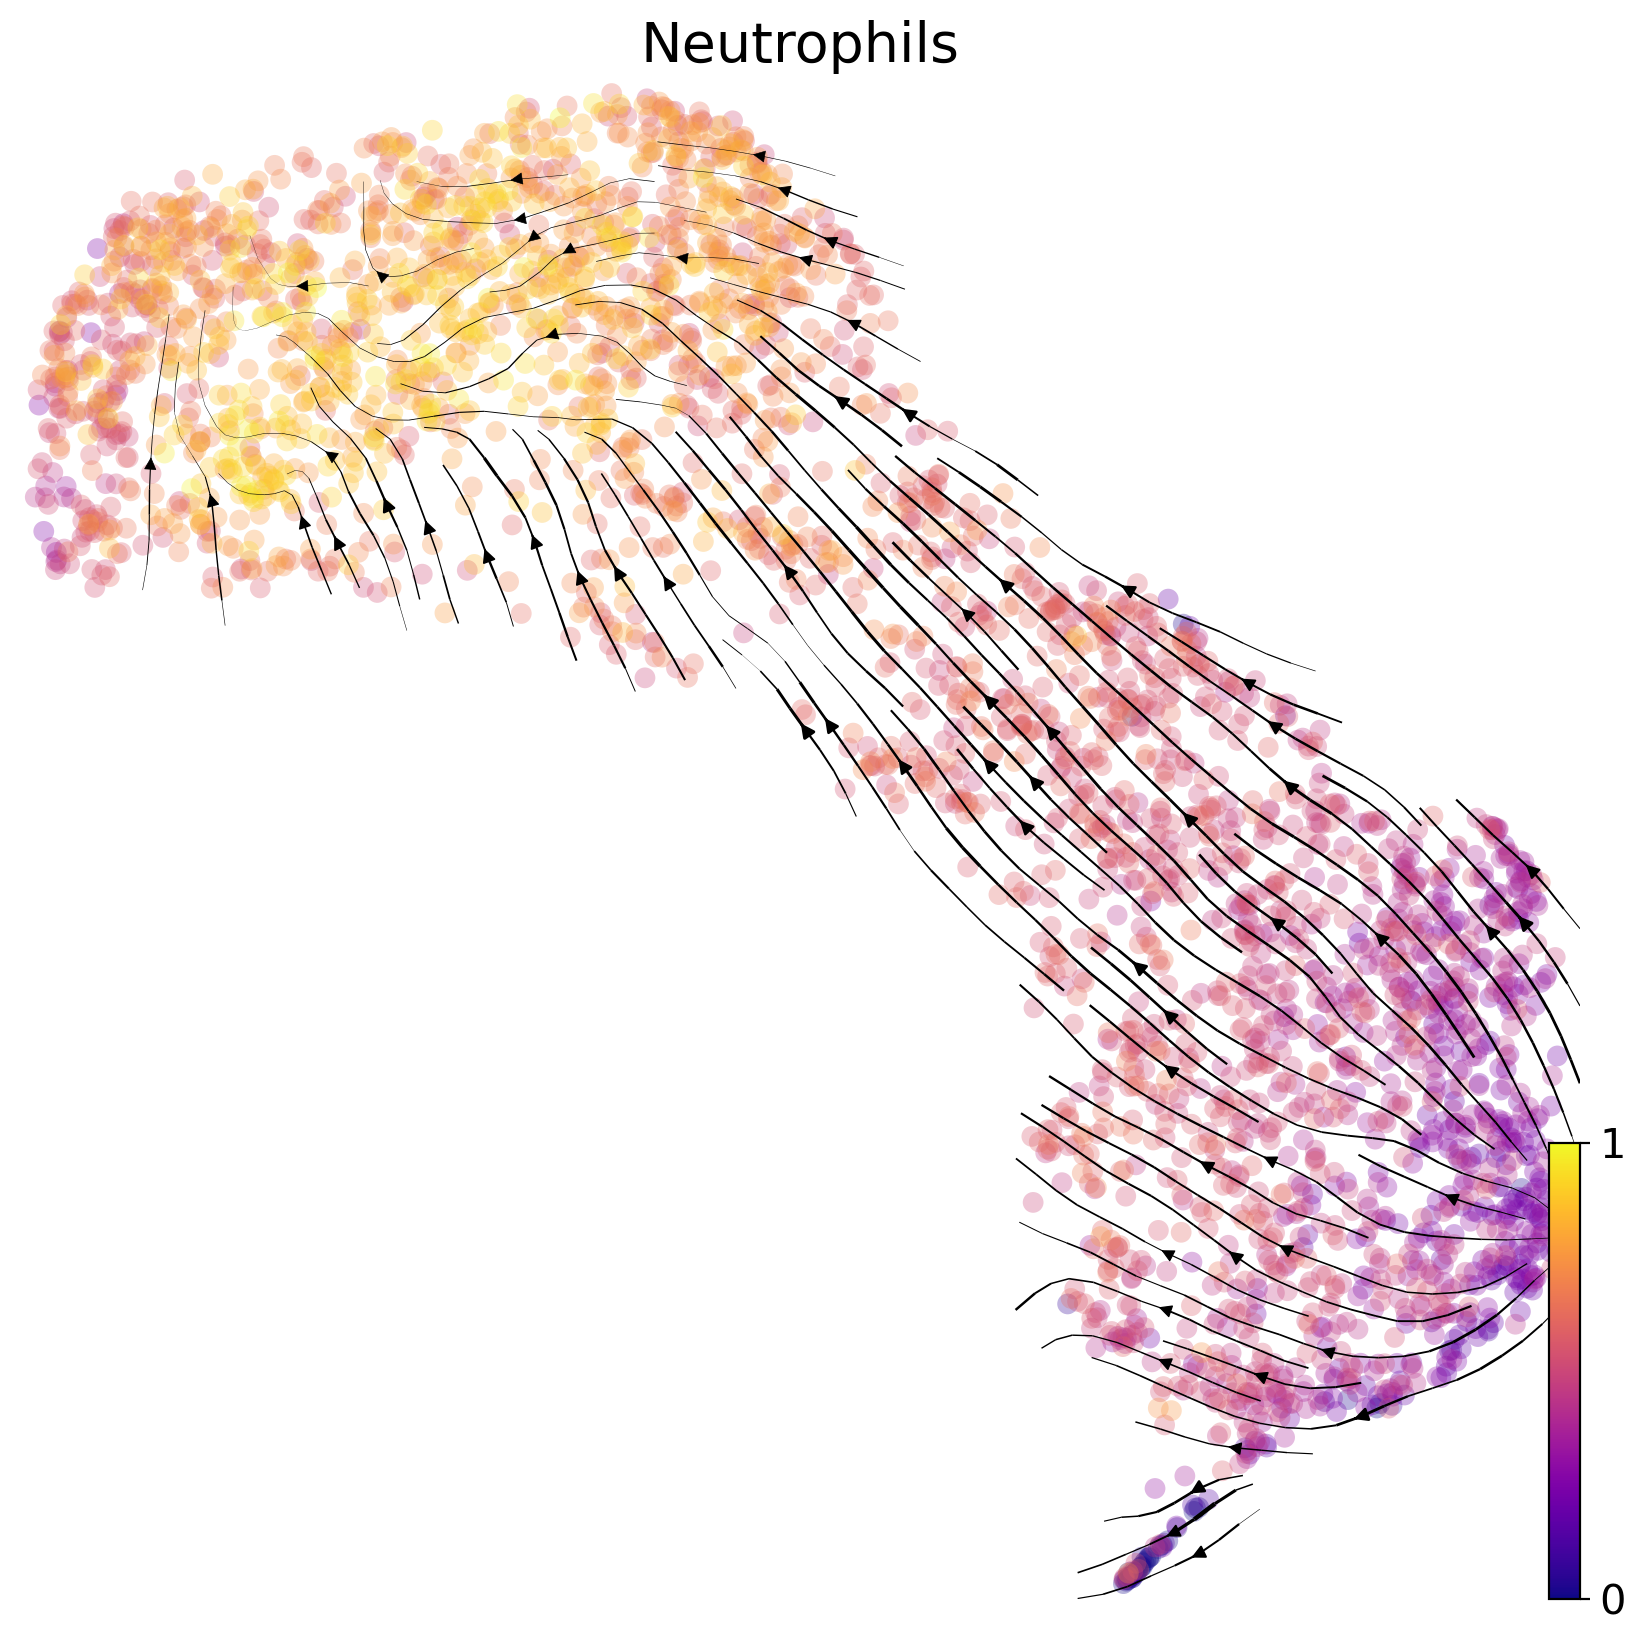

saving figure to file ./figures/scvelo_heatmap_Neutrophils-heatmap.png


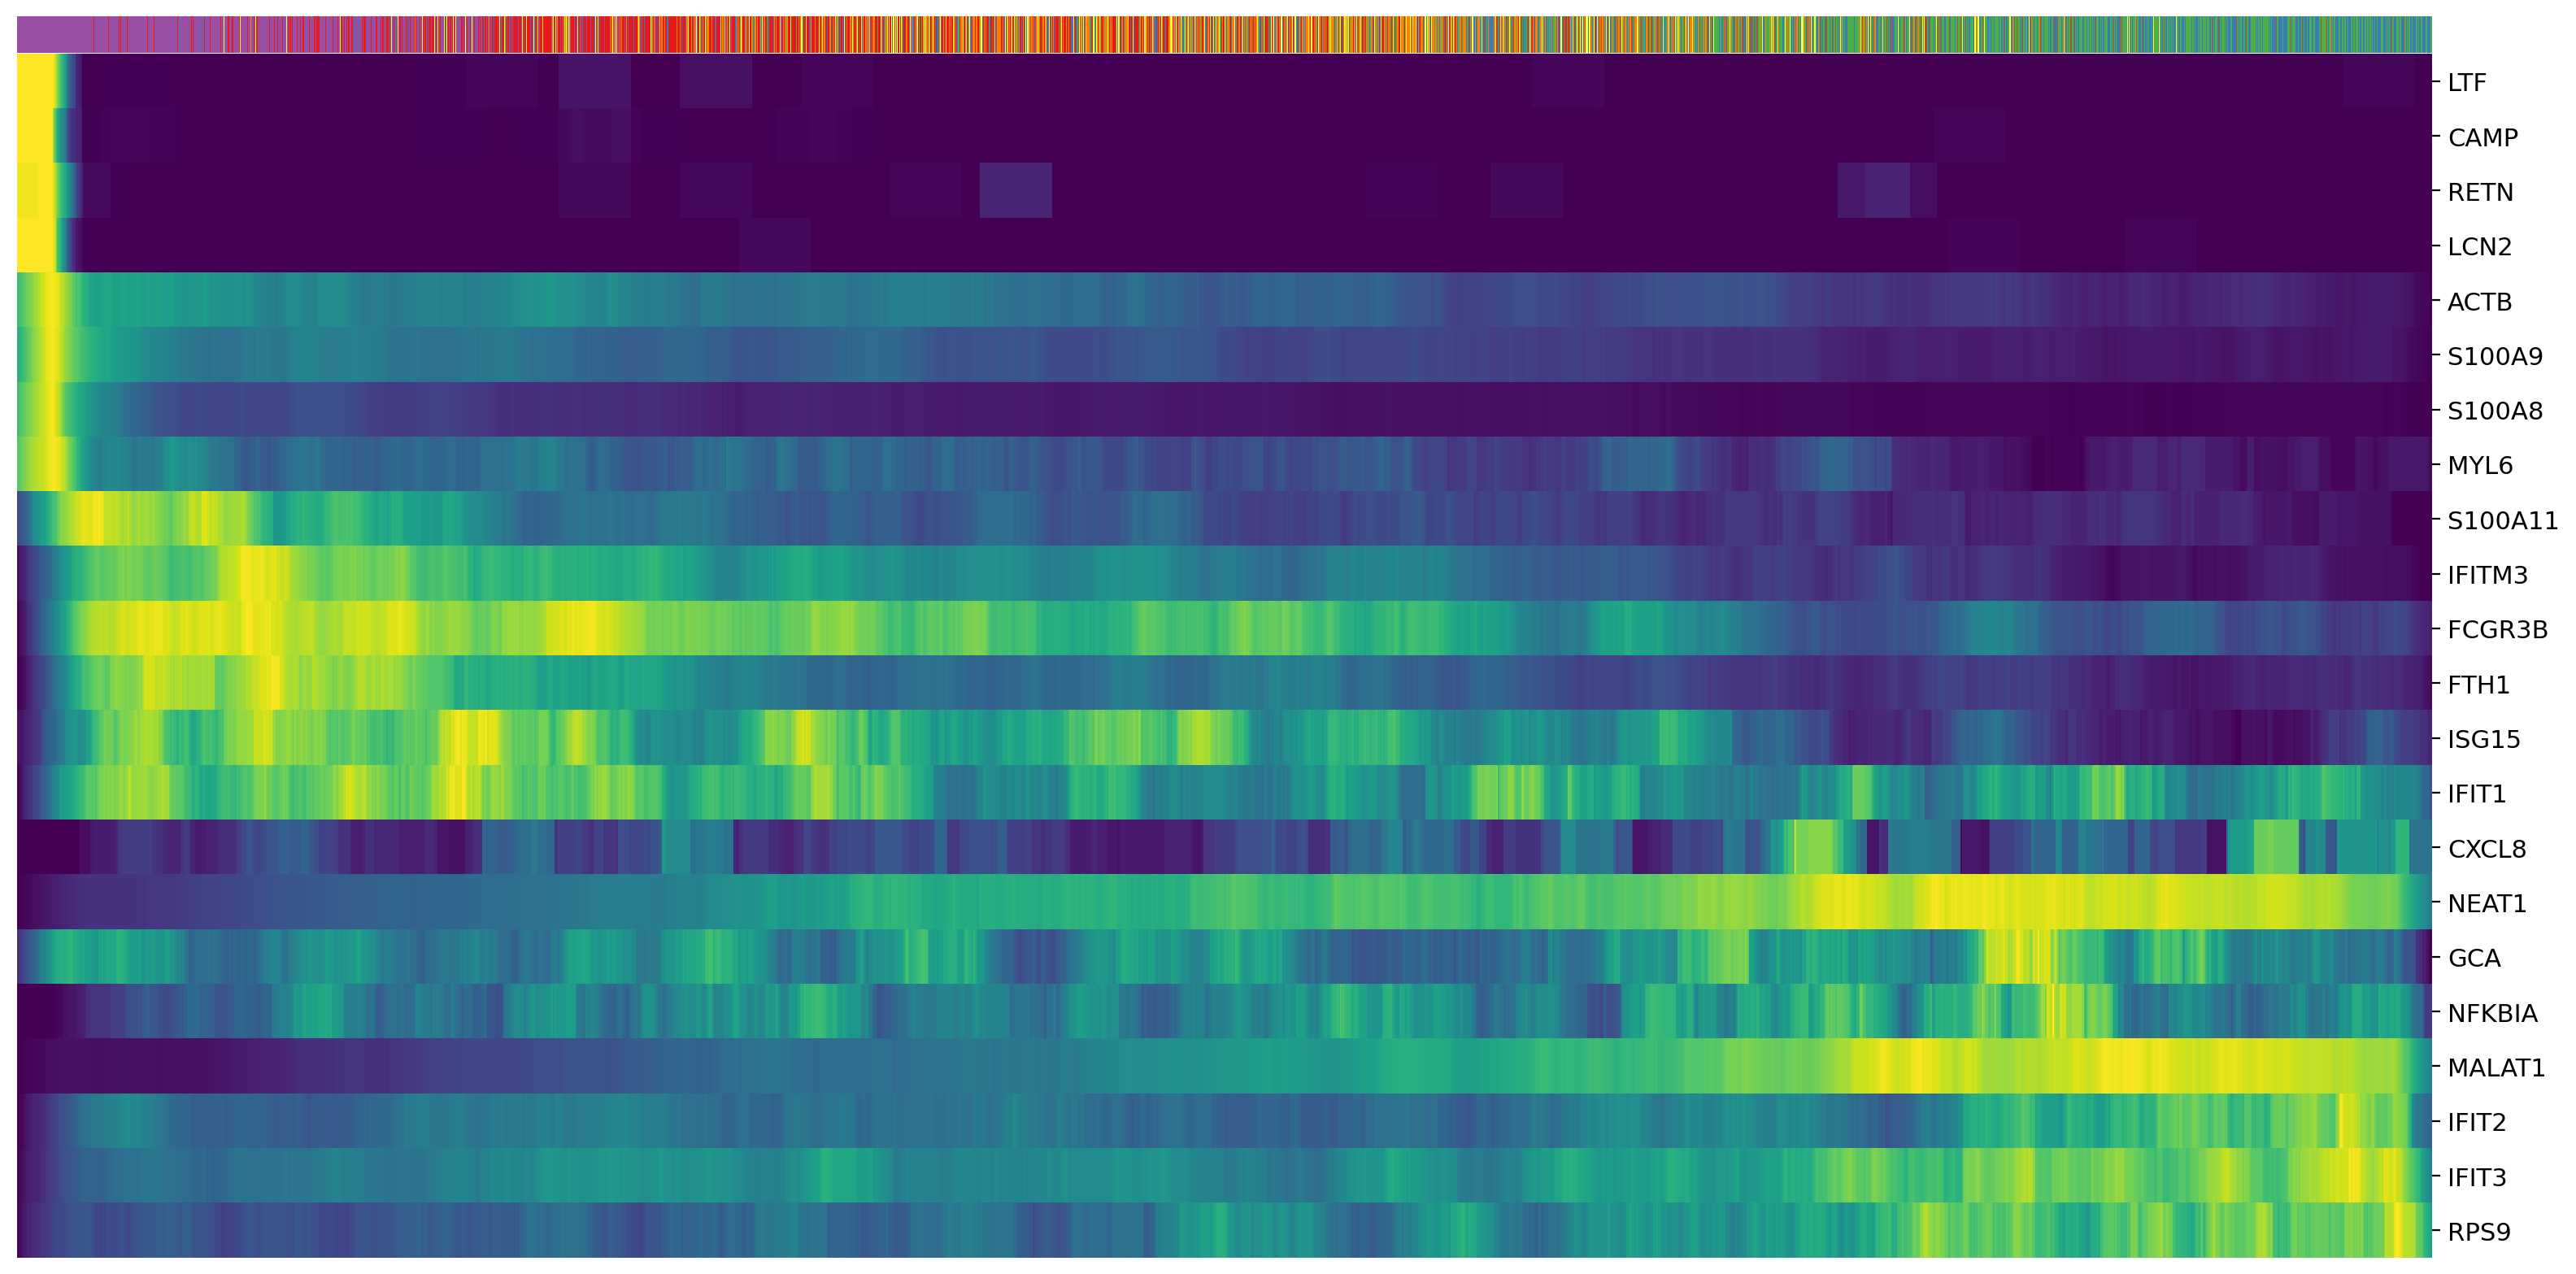

... storing 'feature_types' as categorical


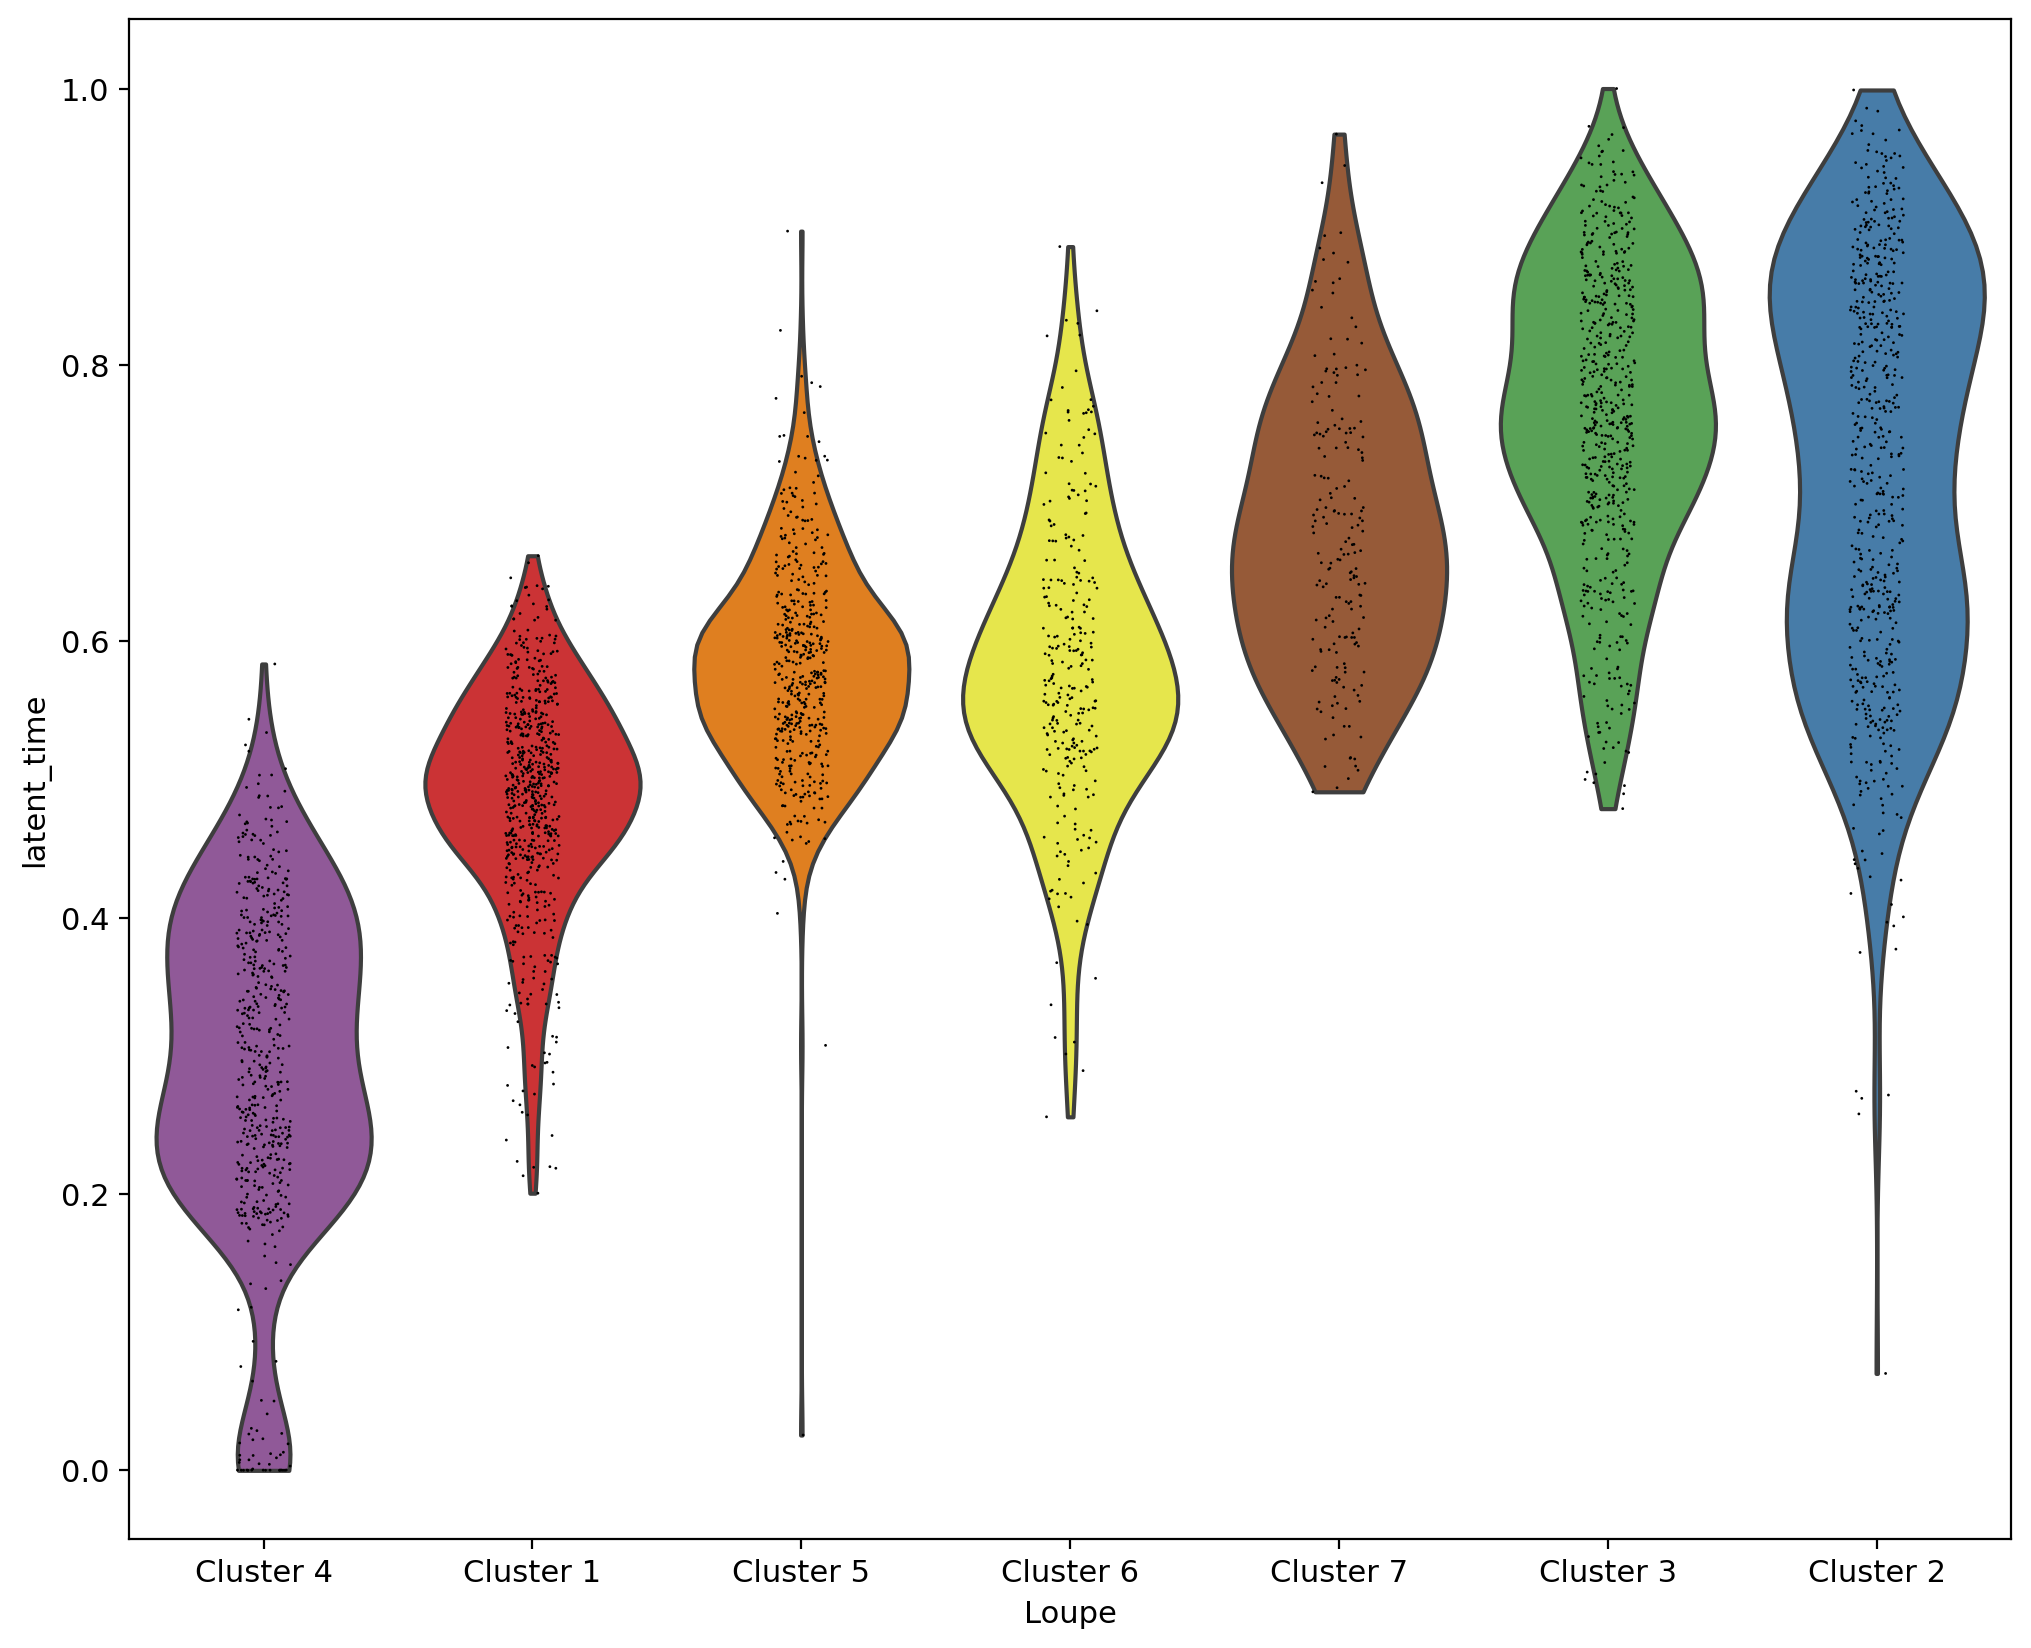

In [11]:
# Visualize the results

scv.pl.velocity_embedding_stream(Neutro3p,basis="umap",color="Loupe",title='Neutrophils',fontsize=20,legend_fontsize=20,min_mass=2,palette=Colorss,save='Neutrophils-scVelo-cluster.png')
scv.pl.velocity_embedding_stream(Neutro3p,basis="umap",color="latent_time",title='Neutrophils',fontsize=20,legend_fontsize=20,min_mass=2,color_map="plasma",save='Neutrophils-scVelo-latenttime.png')

Genes=["RETN","LTF","CAMP","ACTB","GCA","LCN2",
         "S100A8","MYL6","S100A9","FCGR3B","S100A11","FTH1","IFIT1",
         "IFITM3","IFIT3","ISG15","IFIT2","RPS9","NEAT1","MALAT1","NFKBIA","CXCL8"]

scv.pl.heatmap(Neutro3p, var_names=Genes, sortby='latent_time', col_color='Loupe', n_convolve=100,figsize=(16,8),yticklabels=True,sort=True,colorbar=True,show=True,layer="count", save='Neutrophils-heatmap.png')
sc.pl.violin(Neutro3p, keys='latent_time',groupby="Loupe",order=["Cluster 4","Cluster 1","Cluster 5","Cluster 6","Cluster 7","Cluster 3","Cluster 2"], save='Neutrophil-latenttime-violin.png')


> figure cannot be saved as pdf, using png instead.
> saving figure to file ./figures/